In [1]:
# importing necessary modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
from numpy import load
import joblib
import visualkeras

if os.path.abspath('../lib') not in sys.path:
    sys.path.insert(0, os.path.abspath('../lib'))
import util_for_2d_features as util

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)


In [2]:
X, Y = util.get_data()

.. ((7035, 106, 160), (7035,))
.. ((14070, 106, 160), (14070,))
.. ((21108, 106, 160), (21108,))
.. ((28143, 106, 160), (28143,))
.. ((35181, 106, 160), (35181,))


In [3]:
X.shape, Y.shape

((35181, 106, 160), (35181,))

In [4]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

print(Y.shape)
Y[:5]

(35181, 8)


array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.]])

In [5]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, random_state=125, test_size=0.25, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((26385, 106, 160), (26385, 8), (8796, 106, 160), (8796, 8))

In [6]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((26385, 106, 160, 1), (26385, 8), (8796, 106, 160, 1), (8796, 8))

In [7]:
epochs = 100
model_store_path = os.path.join(os.path.abspath('..'), 'data', 'lstm.pkl')
history = joblib.load(model_store_path)
model = history.model

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-02-20 18:17:08         3952
metadata.json                                  2023-02-20 18:17:08           64
variables.h5                                   2023-02-20 18:17:08     42348888
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
...

In [8]:
to_store_at = os.path.join(os.path.abspath('..'), 'data', 'visualize_model_1.png')
visualkeras.layered_view(model, to_file = to_store_at).show()

275/275 [==============================] - 28s 91ms/step - loss: 0.9180 - accuracy: 0.8099
Accuracy of our model on test data :  80.99135756492615 %


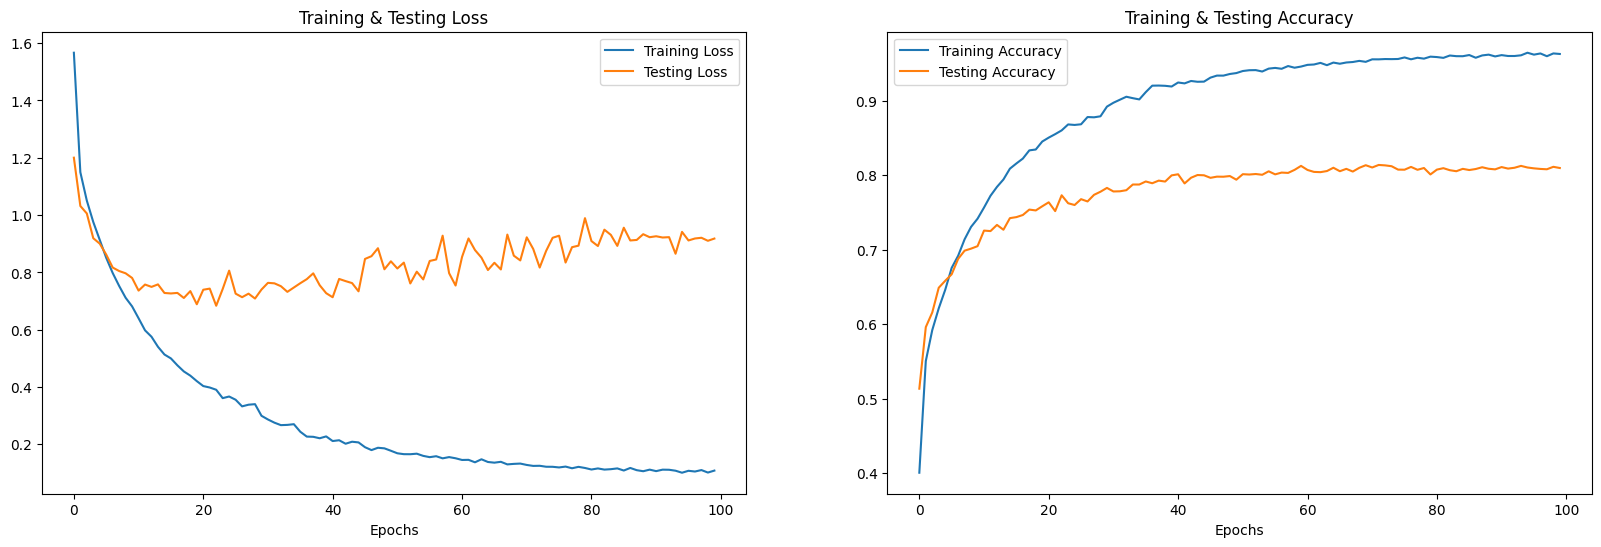

In [9]:
print("Accuracy of our model on test data : ",
      model.evaluate(x_test, y_test)[1]*100, "%")

epochs = [i for i in range(epochs)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
plt.grid(axis='y')

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.grid(axis='y')
plt.show()


In [10]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)


275/275 [==============================] - 27s 95ms/step


In [11]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,sad,sad
1,sad,sad
2,disgust,disgust
3,sad,disgust
4,fear,fear
5,sad,sad
6,disgust,disgust
7,fear,fear
8,neutral,neutral
9,fear,fear


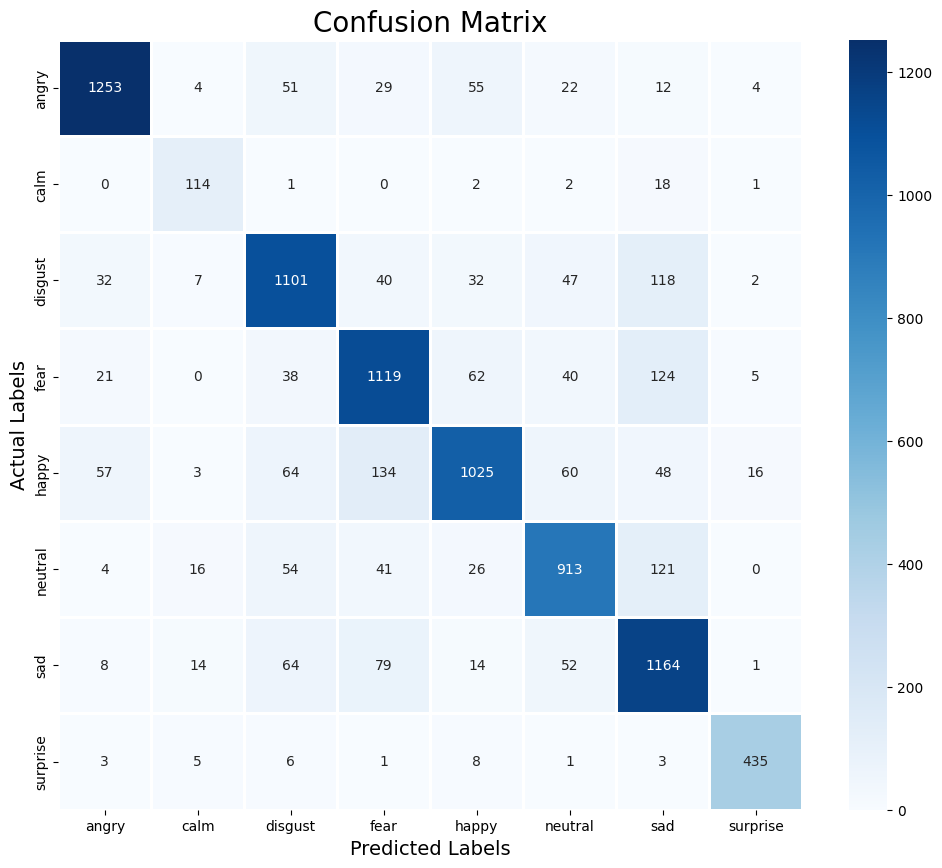

In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
                  i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues',
            linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.91      0.88      0.89      1430
        calm       0.70      0.83      0.76       138
     disgust       0.80      0.80      0.80      1379
        fear       0.78      0.79      0.78      1409
       happy       0.84      0.73      0.78      1407
     neutral       0.80      0.78      0.79      1175
         sad       0.72      0.83      0.77      1396
    surprise       0.94      0.94      0.94       462

    accuracy                           0.81      8796
   macro avg       0.81      0.82      0.81      8796
weighted avg       0.81      0.81      0.81      8796

